In [126]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
import time
from keras import backend as K
from sklearn.model_selection import cross_val_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import r2_score
#from multiprocessing import Pool,cpu_count
import sklearn.metrics as m
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [374]:
'''
Function that takes in a dataframe and then returns the dictionary of accuracies.
'''
'r'
req_columns = ["timestamp","air1","furnace1","waterheater1","total"]

def plot_test(y_test,y_pred,start,end):
    #Plot of testing.
    plt.figure(figsize=(10,10))
    plt.plot(y_test[start:end],'r')
    plt.plot(y_pred[start+1:end],'b')
    plt.xticks(np.arange(0,end-start,1))
    plt.legend()
    plt.show()

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_pred - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_df(localdf):
    i=0
    newdf = []
    timestamp = []
    d = np.zeros((7,))
    newhr = []
    while(24*(i+1)<localdf.shape[0]):
        #print (np.shape(np.sum(localdf.values[24*i:24*(i+1),1:],axis=0).reshape(7,1)),np.sum(localdf.values[24*i:24*(i+1),1:],axis=0).reshape(7,1))
        d = np.sum(localdf.values[24*i:24*(i+1),1:],axis=0)
        newhr.append(localdf.values[24*i:24*(i+1),-1])
        timestamp.append(localdf.values[24*i,0])
        newdf.append(d.T)
        i += 1
    
    print ("End i: ",i)
    
    newdf = np.hstack((np.reshape(timestamp,(-1,1)),newdf))
    newsum = []
    
    #newdf = newdf[start:end]
    #newhr = newhr[start:end]
    #newdf = newdf[:,[0,1,4,6]]
    d = pd.DataFrame(newdf,columns=["timestamp","air1","furnace1","waterheater1"])
    d['total_load'] = d["air1"] + d["furnace1"] + d["waterheater1"]
    print (d.head())
    newdf = d.values
    
    print (newdf.shape)
    return newdf,newhr
  


def nn_model(localdf,localdict,times,metric,num_cols,hour_day):
    for counter in range(times):
            #i = num_cols
        #for i in range(num_cols):
            i=num_cols
            df = pd.DataFrame()
            if(i != 0):
                #print(localdf.columns[i])
                #df = localdf[localdf.columns[i]]
                
                #ndf = pd.concat([df.shift(24),df.shift(23),df.shift(22),df.shift(21),df.shift(20),df.shift(19),df.shift(18),df.shift(17),df.shift(16),df.shift(15),df.shift(14),df.shift(13),df.shift(12),df.shift(11),df.shift(10),df.shift(9),df.shift(8),df.shift(7),df.shift(6),df.shift(5),df.shift(4),df.shift(3),df.shift(2), df.shift(1), df], axis=1)
                #ndf.columns = ('t-24','t-23','t-22','t-21','t-20','t-19','t-18','t-17','t-16','t-15','t-14','t-13','t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1','t')
                #ndf = ndf.iloc[24:]
                #hour_day = hour_day.iloc[24:]
                #print (ndf.head())
                #print (ndf.tail())
                #print (ndf.columns)
                #Function returns Day loads and total load also separately
                ndf,nhr = create_df(localdf)
                print ("Inside nn : ",ndf.shape)
                ndf = pd.DataFrame(ndf,columns = req_columns)
                print (ndf.head())
                #To get the total load of the days
                df = pd.DataFrame(ndf.values[:,-1])
                # To collate d1 to d7
                ndf = pd.concat([df.shift(7),df.shift(6),df.shift(5),df.shift(4),df.shift(3),df.shift(2),df.shift(1),df.shift(0)],axis=1)
                ndf.columns = ('t-7','t-6','t-5','t-4','t-3','t-2','t-1','t')
                print ("mean :",ndf['t'].mean(),"max:",ndf['t'].max(),"min:",ndf['t'].min())
                
                #Creating a df for input and ground truth
                '''newdata = pd.DataFrame(np.hstack((nhr,ndf)))
                newop = ndf.values[:,1]
                '''
                x = ndf.values[7:,:-1]#np.hstack((ndf.values[7:-1],nhr[7:-1]))
                y = ndf.values[7:,-1]
                
                print (x.shape,y.shape)
                #ndf = pd.concat([ndf,hour_day],axis=1)
                #x = pd.concat([x,hour_day],axis=1)
                #print ("\n",y.shape)
                #x = ndf[ndf.columns[0:24]]
                #print (x.shape)
                #print (y.shape)
                print (ndf.describe())
                #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)
                train_size = int(x.shape[0]*0.7)
                X_train = x[:train_size]
                y_train = y[:train_size]
                    
                X_test = x[train_size:]
                y_test = y[train_size:]
                print ("Split done ",X_train.shape,X_test.shape,y_train.shape,y_test.shape,)
                model=ExtraTreesRegressor(n_estimators=500,max_features=None,verbose=1)
                model.fit(X_train,y_train)
#                 model = Sequential()
#                 model.add(Dense(15,input_dim=7,kernel_initializer='normal', activation='relu'))
#                 #Output Layer.
#                 model.add(Dense(1,kernel_initializer='normal'))
#                 #Compile model.
#                 model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])
#                 #Fit the model.
#                 history = model.fit(X_train,y_train,epochs=2000,batch_size=32,verbose=1)
#                 #Final Evaluation of the model.
                #model.evaluate returns the 'loss' and the 'metrics' for the model.
                scores = 0#model.evaluate(X_test,y_test,verbose=1)
                y_pred = model.predict(X_test)
                
                y_pred[y_pred<0]=0
                
                print ("R2 Score : ",r2_score(y_test,y_pred))
                print ("MSE : ",mean_squared_error(y_test[:-1],y_pred[1:]))
                print ("MAE : ",mean_absolute_error(y_test[:-1],y_pred[1:]))
                
                #print (str(coeff_determination(y_test,y_pred)))
#               print ("Metric : %.5f" % (scores[1]))
                localdict["R2"] = r2_score(y_test,y_pred)
                localdict["MSE"] = mean_squared_error(y_test[:-1],y_pred[1:])
                localdict["MAE"] = mean_absolute_error(y_test[:-1],y_pred[1:])       
                #model.summary()
                
                plot_test(y_test,y_pred,0,50)
    return localdict,y_test,y_pred  

total_thermal_load
End i:  1700
                timestamp      air1 furnace1 waterheater1 total_load
0  2013-03-23 08:00:00-05         0  142.417      2567.92    2710.33
1  2013-03-24 08:00:00-05         0  4182.12      1473.55    5655.67
2  2013-03-25 08:00:00-05      0.15  10421.1      5991.67    16412.9
3  2013-03-26 08:00:00-05         0  5657.58      1437.45    7095.03
4  2013-03-27 08:00:00-05  0.133333     3477      4167.75    7644.88
(1700, 5)
Inside nn :  (1700, 5)
                timestamp      air1 furnace1 waterheater1    total
0  2013-03-23 08:00:00-05         0  142.417      2567.92  2710.33
1  2013-03-24 08:00:00-05         0  4182.12      1473.55  5655.67
2  2013-03-25 08:00:00-05      0.15  10421.1      5991.67  16412.9
3  2013-03-26 08:00:00-05         0  5657.58      1437.45  7095.03
4  2013-03-27 08:00:00-05  0.133333     3477      4167.75  7644.88
mean : 9800.74909804 max: 69395.66666666667 min: 484.6499999999999
(1693, 7) (1693,)
                t-7          t-6  

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.48461585062
MSE :  8666491.71516
MAE :  2066.81403616


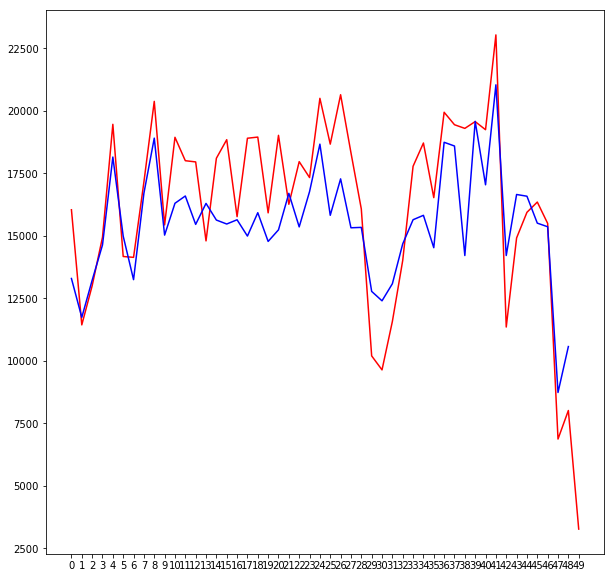

Time Taken :  1.256361722946167
{'R2': 0.4846158506201016, 'MSE': 8666491.7151645869, 'MAE': 2066.8140361604205}


In [342]:
'''
Running extra trees regressor considering only 'air1','furnace1' and 'heater1'.

When run on all the columns,

    R2 Score :  0.655251774638
    MSE :  11932325.3493
    MAE :  2530.18096515
'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

In [365]:
'''
Results on house_id : 1632.

Running the model and comparing on other houses.
'''
hid = [1037,115,2401,3268,3273,4000,6324,6614,8730,9912]
#for i in range(len(hid)):
d_total = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(hid[1])+".pkl")
d_total.isnull().sum()
d_total = d_total[["localhour","air1","furnace1","waterheater1"]]
d_total = d_total*1000

thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(d_total,thermal_dict,1,"mean_squared_error",4,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)


dataid                      0
localhour                   0
use                         0
air1                        0
air2                    27737
air3                    27737
airwindowunit1          27737
aquarium1               27737
bathroom1               27737
bathroom2               27737
bedroom1                27737
bedroom2                27737
bedroom3                27737
bedroom4                27737
bedroom5                27737
car1                    27737
clotheswasher1              0
clotheswasher_dryg1     27737
diningroom1             27737
diningroom2             27737
dishwasher1                 0
disposal1               27737
drye1                       0
dryg1                   27737
freezer1                27737
furnace1                    0
furnace2                27737
garage1                 27737
garage2                 27737
gen                     27737
                        ...  
lights_plugs1           27737
lights_plugs2           27737
lights_plu




House :  1037
End i:  450
                                           timestamp air1 furnace1  \
0  2014-02-07 19:00:00-062014-02-07 19:00:00-0620...    0  20428.5   
1  2014-02-08 19:00:00-062014-02-08 19:00:00-0620...    0   7923.2   
2  2014-02-09 19:00:00-062014-02-09 19:00:00-0620...    0  11310.3   
3  2014-02-10 19:00:00-062014-02-10 19:00:00-0620...    0  27065.6   
4  2014-02-11 19:00:00-062014-02-11 19:00:00-0620...    0  21793.3   

  waterheater1 total_load  
0         3045    23473.5  
1      1036.67    8959.87  
2      3513.15    14823.5  
3      1186.97    28252.6  
4       2429.2    24222.5  
(450, 5)
Inside nn :  (450, 5)
                                           timestamp air1 furnace1  \
0  2014-02-07 19:00:00-062014-02-07 19:00:00-0620...    0  20428.5   
1  2014-02-08 19:00:00-062014-02-08 19:00:00-0620...    0   7923.2   
2  2014-02-09 19:00:00-062014-02-09 19:00:00-0620...    0  11310.3   
3  2014-02-10 19:00:00-062014-02-10 19:00:00-0620...    0  27065.6   
4

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.434548783506
MSE :  32157579.0145
MAE :  3364.98024823


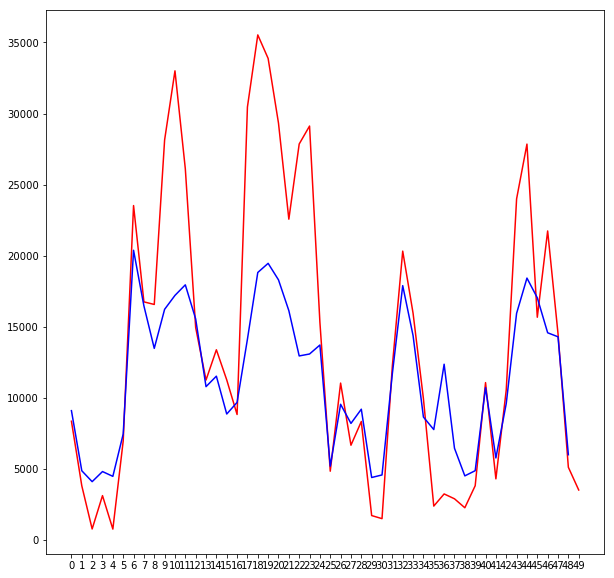

Time Taken :  2.698700428009033
{'R2': 0.43454878350594262, 'MSE': 32157579.014462627, 'MAE': 3364.9802482323157}



House :  115
End i:  1155
                                           timestamp air1 furnace1  \
0  2014-01-24 19:00:00-062014-01-24 19:00:00-0620...    0  19820.9   
1  2014-01-25 19:00:00-062014-01-25 19:00:00-0620...    0  5199.87   
2  2014-01-26 19:00:00-062014-01-26 19:00:00-0620...    0  19829.8   
3  2014-01-27 19:00:00-062014-01-27 19:00:00-0620...    0  39658.6   
4  2014-01-28 19:00:00-062014-01-28 19:00:00-0620...    0  31764.2   

  waterheater1 total_load  
0       1102.5    20923.4  
1      1241.45    6441.32  
2      1227.93    21057.7  
3         1931    41589.6  
4      1681.98    33446.2  
(1155, 5)
Inside nn :  (1155, 5)
                                           timestamp air1 furnace1  \
0  2014-01-24 19:00:00-062014-01-24 19:00:00-0620...    0  19820.9   
1  2014-01-25 19:00:00-062014-01-25 19:00:00-0620...    0  5199.87   
2  2014-01-26 19:00:00-06

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


R2 Score :  0.728711602003
MSE :  5757623.82411


/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


MAE :  1809.29476076


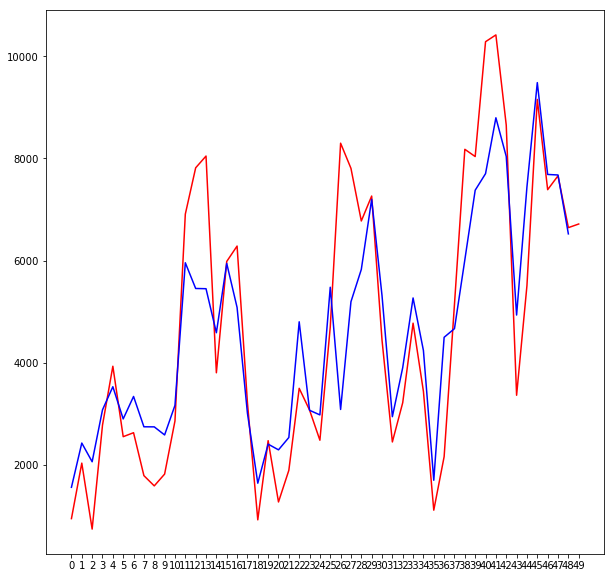

Time Taken :  11.77949070930481
{'R2': 0.72871160200314877, 'MSE': 5757623.8241089191, 'MAE': 1809.2947607558119}



House :  2401
End i:  1231
                                           timestamp air1 furnace1  \
0  2014-01-04 19:00:00-062014-01-04 19:00:00-0620...    0    11807   
1  2014-01-05 19:00:00-062014-01-05 19:00:00-0620...    0  50385.7   
2  2014-01-06 19:00:00-062014-01-06 19:00:00-0620...    0    25804   
3  2014-01-07 19:00:00-062014-01-07 19:00:00-0620...    0  11727.4   
4  2014-01-08 19:00:00-062014-01-08 19:00:00-0620...    0  3327.92   

  waterheater1 total_load  
0         4309      16116  
1      2906.05    53291.7  
2      1604.37    27408.3  
3      2407.25    14134.7  
4      2433.78     5761.7  
(1231, 5)
Inside nn :  (1231, 5)
                                           timestamp air1 furnace1  \
0  2014-01-04 19:00:00-062014-01-04 19:00:00-0620...    0    11807   
1  2014-01-05 19:00:00-062014-01-05 19:00:00-0620...    0  50385.7   
2  2014-01-06 19:00:00-0

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.504374429137
MSE :  13058135.8102
MAE :  2522.7805753


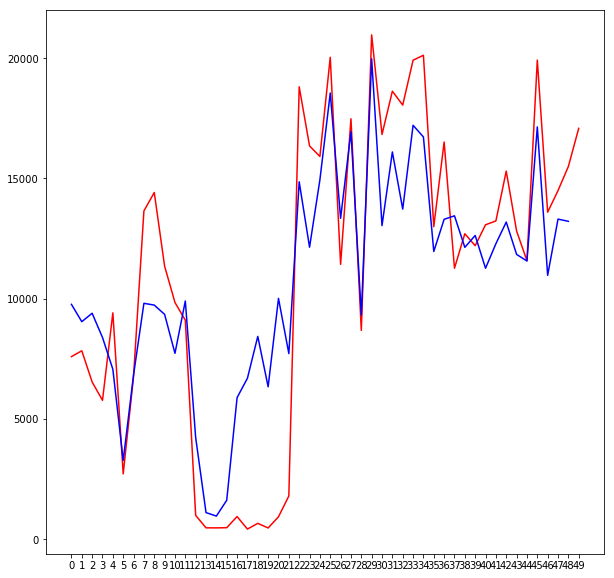

Time Taken :  13.146062135696411
{'R2': 0.50437442913681663, 'MSE': 13058135.810208688, 'MAE': 2522.7805752951936}



House :  3268
End i:  1083
                                           timestamp      air1 furnace1  \
0  2014-01-29 19:00:00-062014-01-29 19:00:00-0620...   1.08333  31901.1   
1  2014-01-30 19:00:00-062014-01-30 19:00:00-0620...  0.983333  2331.65   
2  2014-01-31 19:00:00-062014-01-31 19:00:00-0620...       0.7        0   
3  2014-02-01 19:00:00-062014-02-01 19:00:00-0620...   1.06667  11474.7   
4  2014-02-02 19:00:00-062014-02-02 19:00:00-0620...   5.08333  18486.8   

  waterheater1 total_load  
0      740.283    32642.5  
1      738.483    3071.12  
2      523.233    523.933  
3      725.517    12201.3  
4      3130.28    21622.1  
(1083, 5)
Inside nn :  (1083, 5)
                                           timestamp      air1 furnace1  \
0  2014-01-29 19:00:00-062014-01-29 19:00:00-0620...   1.08333  31901.1   
1  2014-01-30 19:00:00-062014-01-30 19:00:00-0620... 

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.373477823058
MSE :  4485004.74785
MAE :  1102.71338069


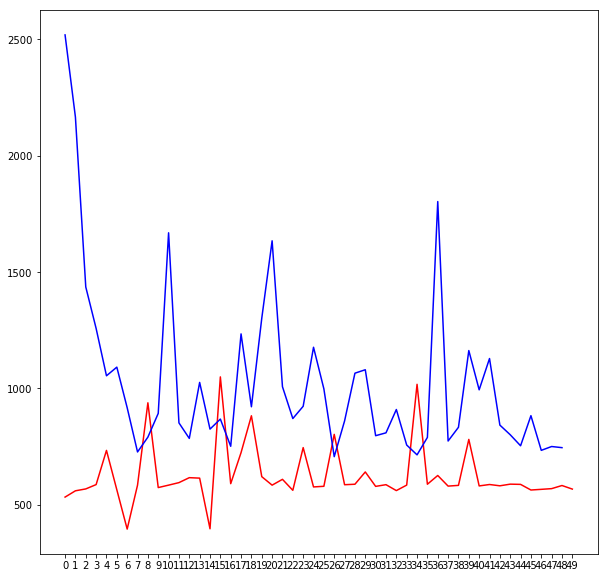

Time Taken :  10.447350263595581
{'R2': 0.37347782305764388, 'MSE': 4485004.747846555, 'MAE': 1102.7133806935817}



House :  3273
End i:  1385
                                           timestamp  air1 furnace1  \
0  2013-12-17 19:00:00-062013-12-17 19:00:00-0620...  0.55     2.95   
1  2013-12-18 19:00:00-062013-12-18 19:00:00-0620...     0      2.4   
2  2013-12-19 19:00:00-062013-12-19 19:00:00-0620...     0        0   
3  2013-12-20 19:00:00-062013-12-20 19:00:00-0620...     0  3.48333   
4  2013-12-21 19:00:00-062013-12-21 19:00:00-0620...     0     2.65   

  waterheater1 total_load  
0      3421.87    3425.37  
1      5774.15    5776.55  
2         1621       1621  
3      8605.05    8608.53  
4      3465.72    3468.37  
(1385, 5)
Inside nn :  (1385, 5)
                                           timestamp  air1 furnace1  \
0  2013-12-17 19:00:00-062013-12-17 19:00:00-0620...  0.55     2.95   
1  2013-12-18 19:00:00-062013-12-18 19:00:00-0620...     0      2.4   
2  2013-12-19 1

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.346537183578
MSE :  3624295.83749
MAE :  1476.6644996


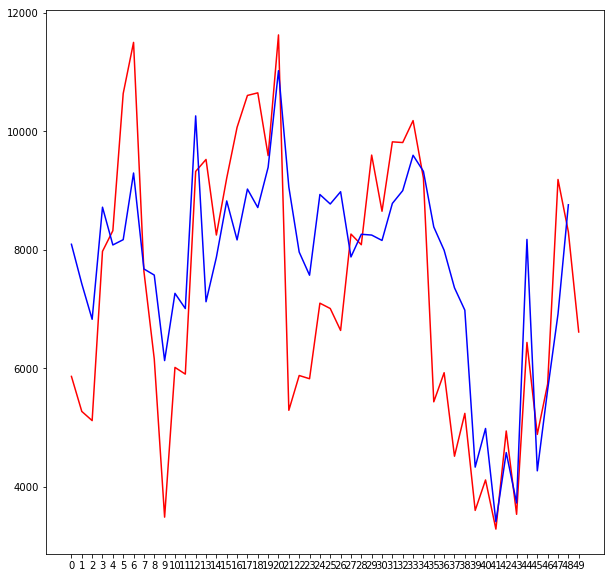

Time Taken :  16.303638219833374
{'R2': 0.34653718357812624, 'MSE': 3624295.8374922005, 'MAE': 1476.6644995964484}



House :  4000
End i:  305
                                           timestamp     air1 furnace1  \
0  2014-01-29 19:00:00-062014-01-29 19:00:00-0620...      6.6  13293.8   
1  2014-01-30 19:00:00-062014-01-30 19:00:00-0620...    12.05  2454.37   
2  2014-01-31 19:00:00-062014-01-31 19:00:00-0620...  12.2667        0   
3  2014-02-01 19:00:00-062014-02-01 19:00:00-0620...     7.15  4171.87   
4  2014-02-02 19:00:00-062014-02-02 19:00:00-0620...  12.5167  14696.3   

  waterheater1 total_load  
0      3747.68    17048.1  
1      6504.68     8971.1  
2       6800.6    6812.87  
3      4112.43    8291.45  
4      6781.08    21489.9  
(305, 5)
Inside nn :  (305, 5)
                                           timestamp     air1 furnace1  \
0  2014-01-29 19:00:00-062014-01-29 19:00:00-0620...      6.6  13293.8   
1  2014-01-30 19:00:00-062014-01-30 19:00:00-0620...    12.05  2

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(90,)
R2 Score :  -0.436712025775
MSE :  8095843.43115
MAE :  2000.47869064


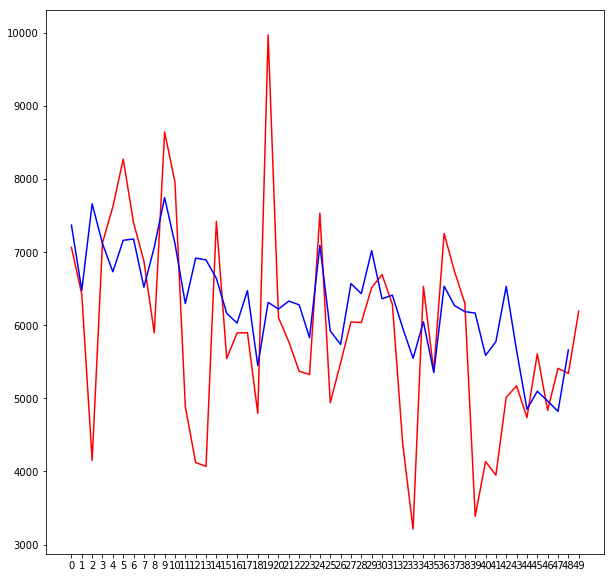

Time Taken :  1.774472951889038
{'R2': -0.43671202577506918, 'MSE': 8095843.4311496234, 'MAE': 2000.4786906367033}



House :  6324
End i:  202
                                           timestamp     air1 furnace1  \
0  2014-12-01 01:00:00-062014-12-01 01:00:00-0620...  4.93333   5745.3   
1  2014-12-02 01:00:00-062014-12-02 01:00:00-0620...  4.73333  5120.58   
2  2014-12-03 01:00:00-062014-12-03 01:00:00-0620...  6.31667  315.283   
3  2014-12-04 01:00:00-062014-12-04 01:00:00-0620...  1.76667     0.35   
4  2014-12-05 01:00:00-062014-12-05 01:00:00-0620...  6.26667        0   

  waterheater1 total_load  
0      2848.73    8598.97  
1      2649.65    7774.97  
2      3462.27    3783.87  
3      1019.75    1021.87  
4      3698.32    3704.58  
(202, 5)
Inside nn :  (202, 5)
                                           timestamp     air1 furnace1  \
0  2014-12-01 01:00:00-062014-12-01 01:00:00-0620...  4.93333   5745.3   
1  2014-12-02 01:00:00-062014-12-02 01:00:00-0620...  4.73333  5

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


 (59, 7) (136,) (59,)
R2 Score :  0.118741206427
MSE :  695506.601102
MAE :  477.606564368


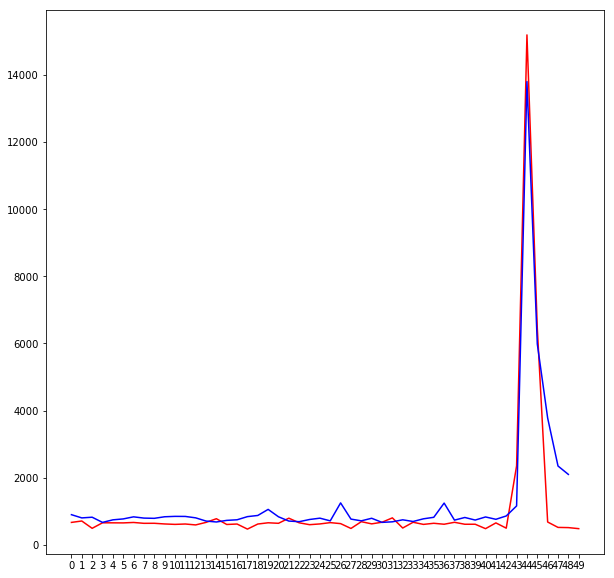

Time Taken :  1.3135075569152832
{'R2': 0.11874120642712749, 'MSE': 695506.60110243259, 'MAE': 477.60656436781812}



House :  6614
End i:  452
                                           timestamp     air1 furnace1  \
0  2013-12-31 19:00:00-062013-12-31 19:00:00-0620...      1.1   2163.2   
1  2014-01-01 19:00:00-062014-01-01 19:00:00-0620...     4.05  9143.13   
2  2014-01-02 19:00:00-062014-01-02 19:00:00-0620...     2.75  7275.53   
3  2014-01-03 19:00:00-062014-01-03 19:00:00-0620...  2.46667  1357.05   
4  2014-01-04 19:00:00-062014-01-04 19:00:00-0620...     2.75  3554.23   

  waterheater1 total_load  
0      1233.62    3397.92  
1      3536.78      12684  
2       2735.6    10013.9  
3      2733.27    4092.78  
4      2073.17    5630.15  
(452, 5)
Inside nn :  (452, 5)
                                           timestamp     air1 furnace1  \
0  2013-12-31 19:00:00-062013-12-31 19:00:00-0620...      1.1   2163.2   
1  2014-01-01 19:00:00-062014-01-01 19:00:00-0620...     4.05  9

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


 (311,) (134,)
R2 Score :  0.12337635032
MSE :  19263698.2293
MAE :  3077.78996491


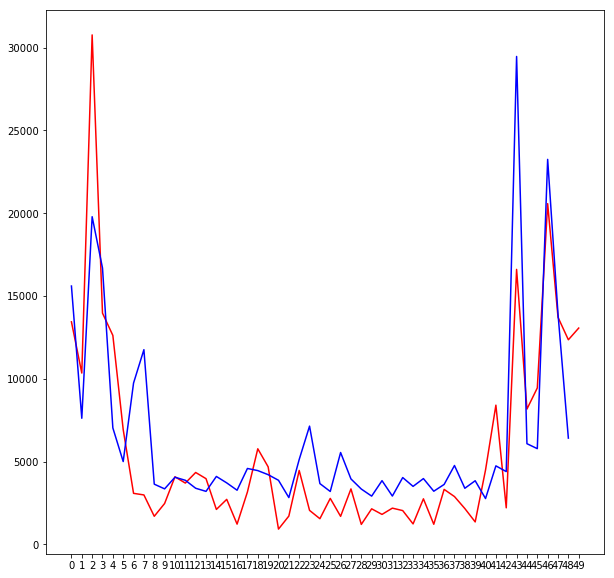

Time Taken :  2.8096253871917725
{'R2': 0.12337635031981431, 'MSE': 19263698.229333445, 'MAE': 3077.7899649122783}



House :  9912
End i:  1286
                                           timestamp     air1 furnace1  \
0  2013-12-31 19:00:00-062013-12-31 19:00:00-0620...      1.5  12388.8   
1  2014-01-01 19:00:00-062014-01-01 19:00:00-0620...     0.95  8235.38   
2  2014-01-02 19:00:00-062014-01-02 19:00:00-0620...  3.13333  11923.3   
3  2014-01-03 19:00:00-062014-01-03 19:00:00-0620...      3.3  6036.62   
4  2014-01-04 19:00:00-062014-01-04 19:00:00-0620...     3.85      402   

  waterheater1 total_load  
0      2183.45    14573.8  
1      1675.95    9912.28  
2       4111.9    16038.4  
3      4647.52    10687.4  
4      5109.57    5515.42  
(1286, 5)
Inside nn :  (1286, 5)
                                           timestamp     air1 furnace1  \
0  2013-12-31 19:00:00-062013-12-31 19:00:00-0620...      1.5  12388.8   
1  2014-01-01 19:00:00-062014-01-01 19:00:00-0620...     0.95

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.524597104224
MSE :  9207148.61127
MAE :  2184.45849869


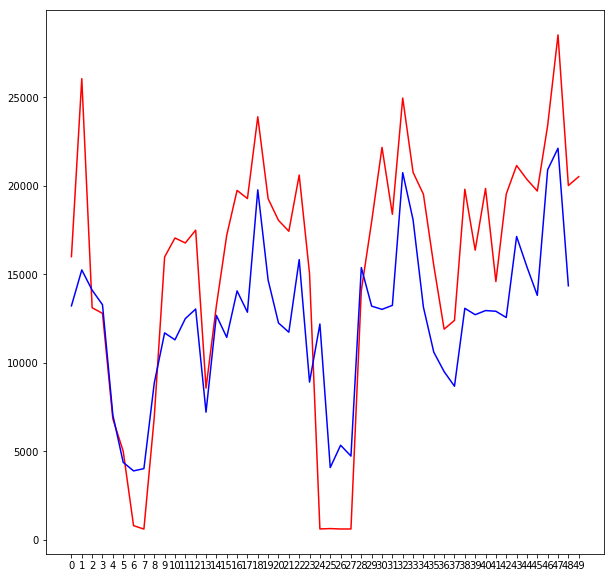

Time Taken :  14.133136510848999
{'R2': 0.52459710422380379, 'MSE': 9207148.611273706, 'MAE': 2184.4584986945179}
[{'R2': 0.52459710422380379, 'MSE': 9207148.611273706, 'MAE': 2184.4584986945179}, {'R2': 0.52459710422380379, 'MSE': 9207148.611273706, 'MAE': 2184.4584986945179}, {'R2': 0.52459710422380379, 'MSE': 9207148.611273706, 'MAE': 2184.4584986945179}, {'R2': 0.52459710422380379, 'MSE': 9207148.611273706, 'MAE': 2184.4584986945179}, {'R2': 0.52459710422380379, 'MSE': 9207148.611273706, 'MAE': 2184.4584986945179}, {'R2': 0.52459710422380379, 'MSE': 9207148.611273706, 'MAE': 2184.4584986945179}, {'R2': 0.52459710422380379, 'MSE': 9207148.611273706, 'MAE': 2184.4584986945179}, {'R2': 0.52459710422380379, 'MSE': 9207148.611273706, 'MAE': 2184.4584986945179}, {'R2': 0.52459710422380379, 'MSE': 9207148.611273706, 'MAE': 2184.4584986945179}]


In [376]:
'''
Results on house_id : 115.

Running the model and comparing on other houses.
'''
d = []

hid = [1037,115,2401,3268,3273,4000,6324,6614,9912]
for i in range(len(hid)):
    print ("\n\n\nHouse : ",hid[i])
    d_total = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(hid[i])+".pkl")
    d_total.isnull().sum()
    d_total = d_total[["localhour","air1","furnace1","waterheater1"]]
    d_total = d_total*1000

    thermal_dict1 = {}
    model_history1 = {}
    ti = time.time()
    thermal_dict1,y_test1,y_pred1 = nn_model(d_total,thermal_dict,1,"mean_squared_error",4,day_hour)
    tf = time.time()

    print ("Time Taken : ",tf-ti)
    print (thermal_dict1)
    d.append(thermal_dict1)

print (d)   

In [76]:
df= pd.read_pickle("../DataSets/New_Pecan_Street/load_data_1632.pkl")
df_new=df

In [77]:
pos=[]
for i in range(3,len(df.columns)):
    if (np.sum(np.isnan(df.iloc[:,i].values))>=40995):
        print ('Empty Column')
        pos.append(i)
    else:
        print ('All fine')
        

All fine
All fine
All fine
Empty Column
Empty Column
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
Empty Column
Empty Column
All fine
All fine
All fine
All fine
Empty Column
All fine
All fine
All fine
All fine
Empty Column
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
All fine
All fine
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
All fine
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
Empty Column
All fine
Empty Column
Empty Column


In [78]:
df_new.drop(df_new.columns[pos], inplace=True, axis=1)

In [79]:
for i in range(3,len(df.columns)):
    print (df.columns[i], np.sum(np.isnan(df.iloc[:,i].values)))

air1 1
air2 1
air3 18
bathroom1 18
clotheswasher1 0
dishwasher1 0
disposal1 0
drye1 40833
dryg1 162
furnace1 18
furnace2 0
garage1 18
garage2 162
grid 1
kitchenapp1 0
kitchenapp2 0
lights_plugs1 18
lights_plugs2 18
lights_plugs3 40851
microwave1 0
outsidelights_plugs1 1
outsidelights_plugs2 1
range1 40851
refrigerator1 7942
waterheater1 18


In [80]:
nuls={}
l=0
for i in range(3,len(df.columns)):
    a=df.iloc[:,i].values
    b=[]
    for j in range (len(a)):
        if np.isnan(a[j])==1:
            b.append(j)
    string = str(i)+"-"+str(np.sum(np.isnan(a)))
    nuls[string]=b


In [81]:
#After removing the entirely NULL columns.
df.isnull().sum()

dataid                      0
localhour                   0
use                         1
air1                        1
air2                        1
air3                       18
bathroom1                  18
clotheswasher1              0
dishwasher1                 0
disposal1                   0
drye1                   40833
dryg1                     162
furnace1                   18
furnace2                    0
garage1                    18
garage2                   162
grid                        1
kitchenapp1                 0
kitchenapp2                 0
lights_plugs1              18
lights_plugs2              18
lights_plugs3           40851
microwave1                  0
outsidelights_plugs1        1
outsidelights_plugs2        1
range1                  40851
refrigerator1            7942
waterheater1               18
dtype: int64

In [82]:
#Dropping the columns : (1) drye1 (2) lights_plugs3 (3)range1 
df.drop(df.columns[[10,21,25]],inplace=True,axis=1)

In [83]:
#After removing the entirely NULL columns.
df.isnull().sum()

dataid                     0
localhour                  0
use                        1
air1                       1
air2                       1
air3                      18
bathroom1                 18
clotheswasher1             0
dishwasher1                0
disposal1                  0
dryg1                    162
furnace1                  18
furnace2                   0
garage1                   18
garage2                  162
grid                       1
kitchenapp1                0
kitchenapp2                0
lights_plugs1             18
lights_plugs2             18
microwave1                 0
outsidelights_plugs1       1
outsidelights_plugs2       1
refrigerator1           7942
waterheater1              18
dtype: int64

In [84]:
df_thermal = df[['dataid','localhour','air1','air2','air3','furnace1','furnace2','waterheater1']]
#Removing the dataid and the localhour column from df_thermal.
del df_thermal[df_thermal.columns[0]]
print (df_thermal.shape)

(40995, 7)


In [85]:
df_thermal.isnull().sum()

localhour        0
air1             1
air2             1
air3            18
furnace1        18
furnace2         0
waterheater1    18
dtype: int64

In [86]:
df_thermal = pd.DataFrame(df_thermal.values[175:],columns=df_thermal.columns)

In [87]:
df_thermal.isnull().sum()

localhour       0
air1            1
air2            1
air3            0
furnace1        0
furnace2        0
waterheater1    0
dtype: int64

In [88]:
print( df_thermal.iloc[34491:34494])
df_thermal.values[34492][1] = (df_thermal.iloc[34492-24*7+1][1] + df_thermal.iloc[34492+24*7+1][1]) / 2
df_thermal.values[34492][2] = (df_thermal.iloc[34292-24*7+1][2] + df_thermal.iloc[34492+24*7+1][2]) / 2
print(df_thermal.iloc[34316-24*7+1],df_thermal.iloc[34316+24*7+1])

                    localhour air1         air2 air3 furnace1 furnace2  \
34491  2017-02-27 10:00:00-06    0  6.66667e-05    0    0.005    0.005   
34492  2017-02-27 11:00:00-06  NaN          NaN    0    0.005    0.005   
34493  2017-02-27 12:00:00-06    0            0    0    0.005    0.005   

      waterheater1  
34491            0  
34492            0  
34493            0  
localhour       2017-02-13 04:00:00-06
air1                                 0
air2                                 0
air3                                 0
furnace1                         0.005
furnace2                         0.005
waterheater1                         0
Name: 34149, dtype: object localhour       2017-02-27 04:00:00-06
air1                                 0
air2                                 0
air3                                 0
furnace1                         0.005
furnace2                         0.005
waterheater1                         0
Name: 34485, dtype: object


In [89]:
#Make it vectorized
day_hour = np.empty([df_thermal.shape[0],1],dtype="int")
for i in range(df_thermal.shape[0]):
    day_hour[i] = df_thermal.values[i][0][11:13]

In [90]:
day_hour = pd.DataFrame(day_hour)
day_hour.columns = ["Hour of the Day"]

In [91]:
df_thermal['total_thermal_load'] = df_thermal['air1'] + df_thermal['air2'] + df_thermal['air3'] + df_thermal['furnace1'] + df_thermal['furnace2'] + df_thermal['waterheater1']

In [92]:
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,0.0059,0.01,0,0.0159
1,2013-03-23 09:00:00-05,0,0,0,0.00491667,0.01,0,0.0149167
2,2013-03-23 10:00:00-05,0,0,0,0.0059,0.0762833,0.181567,0.26375
3,2013-03-23 11:00:00-05,0,0,0,0.0059,0.0760333,1.32477,1.4067
4,2013-03-23 12:00:00-05,0,0,0,0.006,0.01,0,0.016


In [93]:
df_new_thermal = pd.DataFrame(df_thermal,columns=df_thermal.columns)

In [94]:
#Converting 'kwH' into 'Watt Hour'.
df_new_thermal.iloc[:,1:] = df_thermal.iloc[:,1:].mul(1000)

In [95]:
df_new_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,5.9,10,0,15.9
1,2013-03-23 09:00:00-05,0,0,0,4.91667,10,0,14.9167
2,2013-03-23 10:00:00-05,0,0,0,5.9,76.2833,181.567,263.75
3,2013-03-23 11:00:00-05,0,0,0,5.9,76.0333,1324.77,1406.7
4,2013-03-23 12:00:00-05,0,0,0,6,10,0,16


In [96]:
df_new_thermal.iloc[:,6]

0              0
1              0
2        181.567
3        1324.77
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11        121.75
12           186
13             0
14             0
15             0
16             0
17        372.25
18             0
19             0
20             0
21             0
22             0
23       381.583
24             0
25             0
26             0
27             0
28             0
29             0
          ...   
40790          0
40791          0
40792          0
40793    415.317
40794          0
40795          0
40796          0
40797          0
40798          0
40799          0
40800          0
40801          0
40802     403.75
40803          0
40804          0
40805          0
40806          0
40807          0
40808          0
40809          0
40810          0
40811          0
40812          0
40813          0
40814    415.017
40815          0
40816          0
40817         

In [97]:
new_df1,newhr = create_df(df_new_thermal)
newhr = np.array(newhr)
newhr.shape

End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]


(1700, 24)

total_thermal_load
End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]
mean : 14106.0630784 max: 73695.08333333334 min: 552.5999999999999
(1693, 7) (1693,)
                t-7          t-6          t-5          t-4          t-3  \
count   1693.000000  1694.000000  1695.000000  1696.000000  1697.000000   
unique  1691.000000  1692.000000  1693.000000  1694.000000  1695.000000   
top     1067.383333  1067.3833

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.645095410613
MSE :  11976824.04
MAE :  2546.19952581


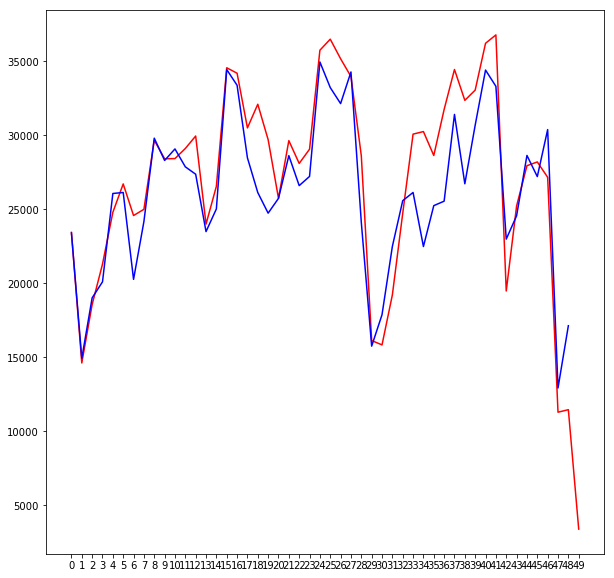

                    localhour air1 air2      air3 furnace1 furnace2  \
0      2013-03-23 08:00:00-05    0    0         0      5.9       10   
1      2013-03-23 09:00:00-05    0    0         0  4.91667       10   
2      2013-03-23 10:00:00-05    0    0         0      5.9  76.2833   
3      2013-03-23 11:00:00-05    0    0         0      5.9  76.0333   
4      2013-03-23 12:00:00-05    0    0         0        6       10   
5      2013-03-23 13:00:00-05    0    0         0        6       10   
6      2013-03-23 14:00:00-05    0    0         0        6       10   
7      2013-03-23 15:00:00-05    0    0         0        6       10   
8      2013-03-23 16:00:00-05    0    0         0        6       10   
9      2013-03-23 17:00:00-05    0    0         0        6       10   
10     2013-03-23 18:00:00-05    0    0         0        6       10   
11     2013-03-23 19:00:00-05    0    0         0  5.96667  10.1167   
12     2013-03-23 20:00:00-05    0    0         0     5.95       10   
13    

In [285]:
thermal_dict = {}
model_history = {}
local_scores=[]
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
print (df_new_thermal)

total_thermal_load
End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]
mean : 14106.0630784 max: 73695.08333333334 min: 552.5999999999999
(1693, 7) (1693,)
                t-7          t-6          t-5          t-4          t-3  \
count   1693.000000  1694.000000  1695.000000  1696.000000  1697.000000   
unique  1691.000000  1692.000000  1693.000000  1694.000000  1695.000000   
top     1067.383333  1067.3833

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.655251774638
MSE :  11932325.3493
MAE :  2530.18096515


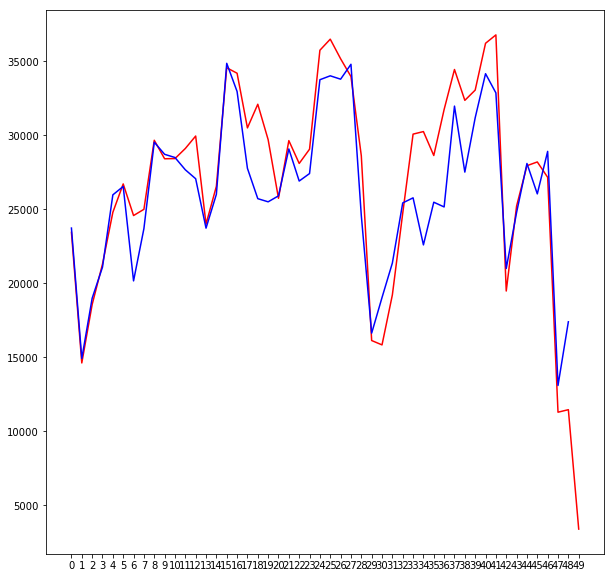

                    localhour air1 air2      air3 furnace1 furnace2  \
0      2013-03-23 08:00:00-05    0    0         0      5.9       10   
1      2013-03-23 09:00:00-05    0    0         0  4.91667       10   
2      2013-03-23 10:00:00-05    0    0         0      5.9  76.2833   
3      2013-03-23 11:00:00-05    0    0         0      5.9  76.0333   
4      2013-03-23 12:00:00-05    0    0         0        6       10   
5      2013-03-23 13:00:00-05    0    0         0        6       10   
6      2013-03-23 14:00:00-05    0    0         0        6       10   
7      2013-03-23 15:00:00-05    0    0         0        6       10   
8      2013-03-23 16:00:00-05    0    0         0        6       10   
9      2013-03-23 17:00:00-05    0    0         0        6       10   
10     2013-03-23 18:00:00-05    0    0         0        6       10   
11     2013-03-23 19:00:00-05    0    0         0  5.96667  10.1167   
12     2013-03-23 20:00:00-05    0    0         0     5.95       10   
13    

In [284]:
thermal_dict = {}
model_history = {}
local_scores=[]
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_new_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
print (df_new_thermal)

In [100]:
df_thermal.head()

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,5.9,10,0,15.9
1,2013-03-23 09:00:00-05,0,0,0,4.91667,10,0,14.9167
2,2013-03-23 10:00:00-05,0,0,0,5.9,76.2833,181.567,263.75
3,2013-03-23 11:00:00-05,0,0,0,5.9,76.0333,1324.77,1406.7
4,2013-03-23 12:00:00-05,0,0,0,6,10,0,16


total_thermal_load
End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 502.5333333333333 2567.916666666667
  3212.866666666667]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 2967.8499999999995 1473.55
  8623.516666666666]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 3787.1333333333337
  5991.666666666666 20200.399999999998]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 120.03333333333333
  823.2333333333331 1065.6666666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 120.26666666666667
  1234.8333333333333 1478.8]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 120.03333333333333
  823.2666666666665 1065.35]]
mean : 14106.0630784 max: 73695.08333333334 min: 552.5999999999999
(1693, 7) (1693,)
                t-7          t-6          t-5          t-4          t-3  \
count   1693.000000  1694.000000  1695.000000  1696.000000  1697.000000   
unique  1691.000000  1692.000000  1693.000000  1694.000000  1695.000000   
top     1067.383333  1067.3833

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


R2 Score :  0.645595532082
MSE :  12614461.876
MAE :  2614.95611555


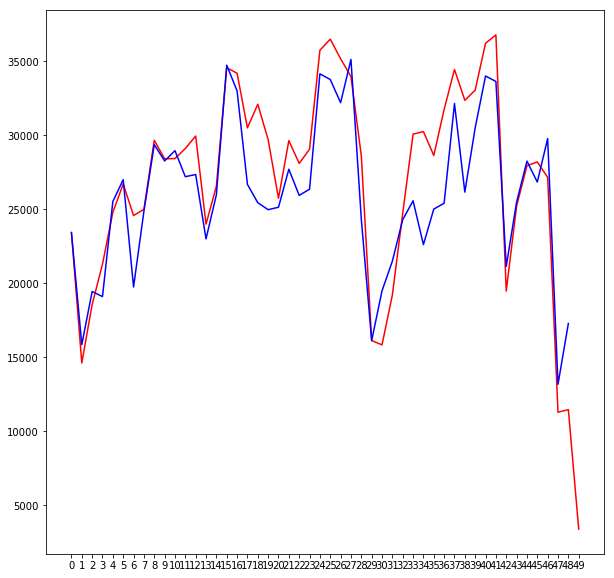

Time Taken :  1.2448928356170654
{'R2': 0.64559553208183162, 'MSE': 12614461.876021359, 'MAE': 2614.9561155489796}


In [286]:
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

In [325]:
'''
Running extra trees regressor considering only 'air1','furnace1' and 'heater1'.
'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour)
tf = time.time()

print ("Time Taken : ",tf-ti)
print (thermal_dict1)

total_thermal_load
End i:  1700
[['2013-03-23 08:00:00-05' 0.0 0.0 ..., 2567.916666666667 3212.866666666667
  2710.3333333333335]
 ['2013-03-24 08:00:00-05' 0.0 0.0 ..., 1473.55 8623.516666666666
  5655.666666666667]
 ['2013-03-25 08:00:00-05' 0.15 0.3833333333333333 ..., 5991.666666666666
  20200.399999999998 16412.88333333333]
 ..., 
 ['2017-11-14 07:00:00-06' 0.0 0.8166666666666665 ..., 823.2333333333331
  1065.6666666666665 943.4166666666665]
 ['2017-11-15 07:00:00-06' 0.0 1.5666666666666667 ..., 1234.8333333333333
  1478.8 1354.9833333333333]
 ['2017-11-16 07:00:00-06' 0.0 0.6833333333333333 ..., 823.2666666666665
  1065.35 943.4333333333332]]


ValueError: Shape of passed values is (9, 1700), indices imply (8, 1700)

In [106]:
print (r2_score(y_test1,y_pred1))

0.646837528077


In [107]:
#With the 'metric' as 'coefficient of determination (r^2)'.
'''
water-heater attribute is always negative when r^2 is used.
'''
thermal_dict1 = thermal_dict
print (thermal_dict1)


{'R2': 0.64683752807672024, 'MSE': 48525374.121808782, 'MAE': 4850.2538556430445}


In [108]:
#With the 'metric' as 'mean_squared_error'.
thermal_dict3 = thermal_dict
print (thermal_dict3)

{'R2': 0.64683752807672024, 'MSE': 48525374.121808782, 'MAE': 4850.2538556430445}


In [109]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_month(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(168), df.shift(24), df], axis=1)
                    ndf.columns = ('t-168', 't-24', 't')
                    ndf = ndf.iloc[168:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [110]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_2hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-2', 't-1', 't')
                    ndf = ndf.iloc[2:]

                    x = ndf[ndf.columns[0:2]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]
                    
                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [111]:
'''
Moving on to 'Extra Trees Regresssor.
'''
def et_4hours(localdf):
    scores=[]
    for i in range(len(localdf.columns)):
                df = pd.DataFrame()
                if(i != 0):
                    #print(localdf.columns[i])
                    df = localdf[localdf.columns[i]]
                    ndf = pd.concat([df.shift(4),df.shift(3),df.shift(2), df.shift(1), df], axis=1)
                    ndf.columns = ('t-4','t-3','t-2', 't-1', 't')
                    ndf = ndf.iloc[4:]

                    x = ndf[ndf.columns[0:4]]
                    y = ndf[ndf.columns[-1:]]
                    
                    #Sequential Split.
                    train_size = int(70*x.shape[0]/100)
                    X_train = x.values[:train_size]
                    y_train = y.values[:train_size]

                    X_test = x.values[train_size:]
                    y_test = y.values[train_size:]
                    
                    print (X_train.shape,y_train.shape)
                    print (X_test.shape,y_test.shape)
                    
                    #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)

                    model = ExtraTreeRegressor()
                    model = model.fit(X_train,y_train)
                    y_pred = model.predict(X_test)
                    #scores.append(r2_score(y_test,y_pred))
                    scores.append(m.mean_squared_error(y_test,y_pred))
                    #scores.append(cross_val_score(model,x.values,y.values,scoring='r2',cv=2))
    return scores          

In [112]:
#Metric : 'r^2'.
scores_2hours = et_2hours(df_thermal)
print (scores_2hours)

(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
[65664.763157168709, 30729.270134204569, 10347.59406247572, 37647.033278020543, 998.29458626169014, 38417.371994865716, 315441.01021544338]


In [113]:
#Metric : 'r^2'.
scores_4hours = et_4hours(df_thermal)
print (scores_4hours)

(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
[64179.543748308344, 31174.264290511008, 10146.549583791384, 42430.600607376786, 1039.7521256057755, 37506.195334307013, 314660.11417068739]


In [114]:
#Metric : 'r^2'.
scores_month = et_month(df_thermal)
print (scores_month)

(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
(28456, 2) (28456, 1)
(12196, 2) (12196, 1)
[103628.7907357698, 51561.39344281052, 31148.040947090645, 110357.90134009351, 1770.8464882859787, 41303.416673699096, 537612.36188027484]


In [115]:
#Metric : 'mse'.
scores_2hours = et_2hours(df_thermal)
print (scores_2hours)

(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
(28572, 2) (28572, 1)
(12246, 2) (12246, 1)
[66329.405505932998, 31472.689678848754, 11133.566424424267, 34212.575054481844, 1051.3436233956415, 36453.796057969339, 317080.16818584083]


In [116]:
#Metric : 'mse'.
scores_4hours = et_4hours(df_thermal)
print (scores_4hours)

(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
(28571, 4) (28571, 1)
(12245, 4) (12245, 1)
[63113.508874811589, 32303.212822949346, 9330.866794732563, 43717.074093591895, 1067.2330125890071, 37286.649639767427, 300314.38493312511]


In [117]:
df_thermal.head(10)

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,5.9,10,0,15.9
1,2013-03-23 09:00:00-05,0,0,0,4.91667,10,0,14.9167
2,2013-03-23 10:00:00-05,0,0,0,5.9,76.2833,181.567,263.75
3,2013-03-23 11:00:00-05,0,0,0,5.9,76.0333,1324.77,1406.7
4,2013-03-23 12:00:00-05,0,0,0,6,10,0,16
5,2013-03-23 13:00:00-05,0,0,0,6,10,0,16
6,2013-03-23 14:00:00-05,0,0,0,6,10,0,16
7,2013-03-23 15:00:00-05,0,0,0,6,10,0,16
8,2013-03-23 16:00:00-05,0,0,0,6,10,0,16
9,2013-03-23 17:00:00-05,0,0,0,6,10,0,16


In [118]:
df_thermal.to_csv("df_thermal.csv",encoding="utf8")

In [119]:
for i in df_thermal.columns:
    print (np.amax(df_thermal[i]))

2017-11-18 02:00:00-06
2399.916666666667
1925.0166666666669
1573.7333333333331
5048.083333333333
1020.6999999999999
1966.583333333333
6313.65


In [120]:
df_thermal.shape

(40820, 8)

In [239]:
df_thermal.head(50)

,localhour,air1,air2,air3,furnace1,furnace2,waterheater1,total_thermal_load
0,2013-03-23 08:00:00-05,0,0,0,5.9,10,0,15.9
1,2013-03-23 09:00:00-05,0,0,0,4.91667,10,0,14.9167
2,2013-03-23 10:00:00-05,0,0,0,5.9,76.2833,181.567,263.75
3,2013-03-23 11:00:00-05,0,0,0,5.9,76.0333,1324.77,1406.7
4,2013-03-23 12:00:00-05,0,0,0,6,10,0,16
5,2013-03-23 13:00:00-05,0,0,0,6,10,0,16
6,2013-03-23 14:00:00-05,0,0,0,6,10,0,16
7,2013-03-23 15:00:00-05,0,0,0,6,10,0,16
8,2013-03-23 16:00:00-05,0,0,0,6,10,0,16
9,2013-03-23 17:00:00-05,0,0,0,6,10,0,16


In [122]:
days = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
columns = np.empty([df_thermal.shape[0],1],dtype=str)
i=0
while i <= (df_thermal.shape[0]-7):
    columns[i]   = 'Saturday'
    columns[i+1] = 'Sunday'
    columns[i+2] = 'Monday'
    columns[i+3] = 'Tuesday'
    columns[i+4] = 'Wednesday'
    columns[i+5] = 'Thursday'
    columns[i+6] = 'Friday'
    i += 7

In [123]:
print (columns[0])

['S']


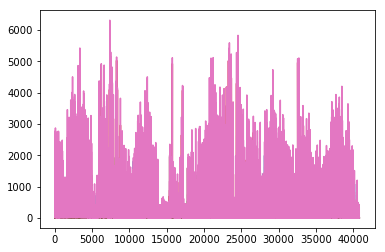

In [124]:
plt.plot(df_thermal.values[:,1:])
plt.show()

In [129]:
for i in range(df_thermal.columns.shape[0]):    
    print ("\nMAX,MIN: ",np.max(df_thermal.values[:,i])," ",np.min(df_thermal.values[:,i]) )


MAX,MIN:  2017-11-18 02:00:00-06   2013-03-23 08:00:00-05

MAX,MIN:  2399.916666666667   0.0

MAX,MIN:  1925.0166666666669   0.0

MAX,MIN:  1573.7333333333331   0.0

MAX,MIN:  5048.083333333333   0.0

MAX,MIN:  1020.6999999999999   0.0

MAX,MIN:  1966.583333333333   0.0

MAX,MIN:  6313.65   0.0


In [166]:
d1 = pd.DataFrame(new_df1[:50,0])

In [167]:
d2 = pd.DataFrame(new_df1[:50,4:6])

In [171]:
d = pd.concat([d1,d2],axis=1)
d.columns = [df_thermal.columns[0],df_thermal.columns[4],df_thermal.columns[5]]
d.head()

,localhour,furnace1,furnace2
0,2013-03-23 08:00:00-05,142.417,502.533
1,2013-03-24 08:00:00-05,4182.12,2967.85
2,2013-03-25 08:00:00-05,10421.1,3787.13
3,2013-03-26 08:00:00-05,5657.58,2665.9
4,2013-03-27 08:00:00-05,3477,1465.53


In [199]:
d_total = pd.DataFrame(df_thermal)
d_total.shape

(40820, 8)

In [217]:
np.amax(d_total)

localhour             2017-11-18 02:00:00-06
air1                                 2399.92
air2                                 1925.02
air3                                 1573.73
furnace1                             5048.08
furnace2                              1020.7
waterheater1                         1966.58
total_thermal_load                   6313.65
dtype: object

In [214]:
unique_1 , counts_1 = np.unique(d_total.values[:,4],return_counts=True)
unique_2 , counts_2 = np.unique(d_total.values[:,5],return_counts=True)

In [287]:
dict_count1 = dict(zip(unique_1,counts_1))
dict_count2 = dict(zip(unique_2,counts_2))
print ("Count of 0's : ",dict_count1[0],dict_count2[0])
print ("Count of 5's : ",dict_count1[5],dict_count2[10])

Count of 0's :  33 33
Count of 5's :  17204 1681


In [263]:
print (np.sum(d_total.values[:,4]==6))
print (np.sum(d_total.values[:,5]==10))

1603
1681


total_thermal_load
End i:  1700
[['2013-05-18 08:00:00-05' 14175.333333333332 1.2166666666666668 0.0
  139.86666666666667 229.5333333333333 395.23333333333323
  14941.183333333334]
 ['2013-05-19 08:00:00-05' 872.3499999999998 0.0 0.0 142.45000000000002
  239.31666666666666 809.2333333333333 2063.35]
 ['2013-05-20 08:00:00-05' 4401.633333333333 0.0 0.0 141.8
  236.54999999999998 816.4166666666665 5596.400000000001]
 ['2013-05-21 08:00:00-05' 3446.4166666666665 0.15 0.0 140.7166666666667
  237.61666666666665 812.1 4636.999999999999]
 ['2013-05-22 08:00:00-05' 3038.1666666666665 0.0 0.0 141.79999999999998
  237.54999999999998 396.4166666666665 3813.9333333333325]
 ['2013-05-23 08:00:00-05' 3438.183333333333 0.0 0.0 142.36666666666665
  237.83333333333334 836.2333333333333 4654.616666666666]
 ['2013-05-24 08:00:00-05' 2.1333333333333333 0.0 0.0 142.31666666666666
  240.0 1191.2333333333331 1575.6833333333332]
 ['2013-05-25 08:00:00-05' 1.3833333333333333 0.0 0.0 143.56666666666666
  240.0 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


R2 Score :  0.196613674397
MSE :  73264694.7325
MAE :  6090.76758908


/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


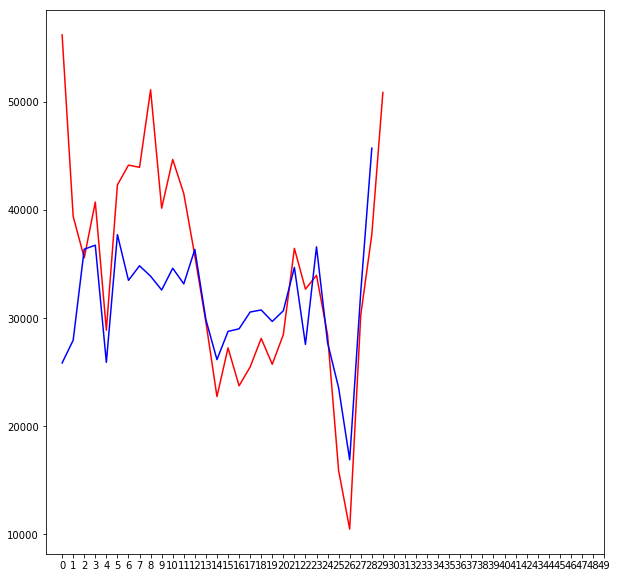

Time Taken :  0.9360499382019043
{'R2': 0.19661367439656907, 'MSE': 73264694.732539609, 'MAE': 6090.7675890804712}


In [276]:
'''
8*7
23*7
'''
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,y_test1,y_pred1 = nn_model(df_thermal,thermal_dict,1,"mean_squared_error",7,day_hour,56,161)
tf = time.time()
print ("Time Taken : ",tf-ti)
print (thermal_dict1)

In [291]:
d_total.values[(np.where(d_total.values[:,4] == 5)[0])]

array([['2013-04-01 00:00:00-05', 0.0, 0.0, ..., 10.0, 388.90000000000003,
        403.90000000000003],
       ['2013-04-15 16:00:00-05', 0.0, 0.0, ..., 9.866666666666665, 0.0,
        14.866666666666667],
       ['2013-06-04 00:00:00-05', 749.7166666666666, 0.0, ...,
        9.266666666666666, 0.0, 763.9833333333332],
       ..., 
       ['2017-11-18 00:00:00-06', 0.0, 0.0, ..., 5.0, 0.0, 10.0],
       ['2017-11-18 01:00:00-06', 0.0, 0.0, ..., 5.0, 0.0, 10.0],
       ['2017-11-18 02:00:00-06', 0.0, 0.0, ..., 5.0, 0.0, 10.0]], dtype=object)

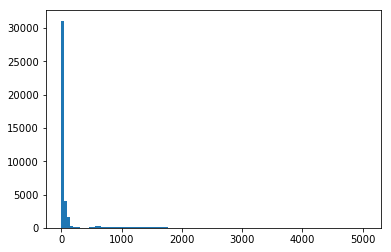

In [297]:
plt.hist((df_thermal.values[:,4]),bins=100)
plt.show()

In [304]:
np.mean(df_thermal.values[:,4])

134.9554850563431

In [302]:
new_df1.shape

(1700, 8)

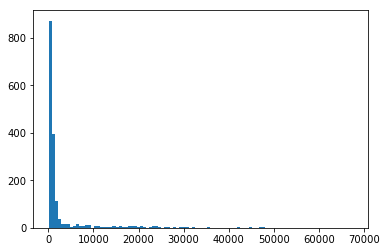

In [298]:
plt.title("Furnace 1")
plt.hist((new_df1[:,4]),bins=100)
plt.show()

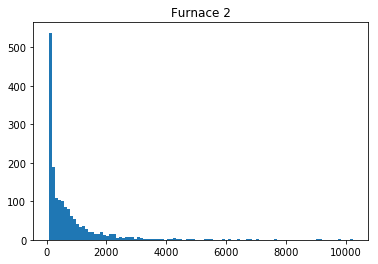

In [303]:
plt.title("Furnace 2")
plt.hist((new_df1[:,5]),bins=100)
plt.show()